In [ ]:
!pip install pypdf
!pip install ddgs
!pip install -U langchain-gigachat langchain-chroma langchain-core langchain-text-splitters langchain-community


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.4.0
    Uninstalling lxml-5.4.0:
      Successfully uninstalled lxml-5.4.0
  Using cached langchain_chroma-1.0.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached langchain_core-1.0.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached langchain_text_splitters-1.0.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached langchain_community-0.4-py3-none-any.whl.metadata (3.0 kB)
INFO: pip is looking at multiple versions of langchain-chroma to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-text-splitters to determine which version is compatible with other requirements. This could take a while.
INFO: pip 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# GigaChat LangGraph

## ReAct-agent with LangGraph

Based on [this](https://habr.com/ru/companies/sberbank/articles/934938/) magnifisent tutorial.

**ReAct** is the foundational pattern that kicked off the era of LLM agents.
But how do we build it today—leveraging modern function calling and **graph-based control flow?**

In this hands-on guide, we trace the evolution of **ReAct** and draw a clear line between **LangChain** `(prompt/tool abstractions, rapid prototyping)` and **LangGraph** `(stateful graphs, deterministic routing, retries, tool-calling orchestration)`.

We implement a flexible ReAct agent on a modern stack and a graph that cleanly separates **Thought → Action → Observation → (Policy)**. No magic—just reproducible code and plain theory you can run end-to-end.

##Evolution of Frameworks

Before diving into the code-level implementation of ReAct agents, it’s worth taking a step back to look at the frameworks that make it possible — **LangChain** and **LangGraph**.

At its core, LangChain provides **a universal toolkit for building LLM applications** — models, chains of calls and transformations, integrations with external data sources, vector stores, and tool interfaces. Its main goal is to accelerate experimentation and development while maintaining flexibility.The fundamental abstraction in LangChain is the **Chain — a directed acyclic graph (DAG) representing a deterministic flow of data from input to output**. This model works perfectly for **structured pipelines where each step is predefined and unidirectional**.

However, agents require a more dynamic flow of control. As the LangChain developers themselves noted, **complex LLM applications often need loops**: an agent must repeatedly call tools, reassess the situation after each observation, ask clarifying questions, or correct mistakes. In short, agentic reasoning is inherently iterative.

In classical LangChain, this iterative logic was encapsulated inside opaque components known as `Agent Executors`. They made getting started easy but introduced a “black box” problem — developers couldn’t easily inspect, debug, or modify the decision-making loop. Recognizing this limitation, the LangChain team introduced LangGraph in early 2024.The key idea was both simple and elegant: **if a Chain is a directed acyclic graph, then an Agent is a graph with cycles**.

**LangGraph extends the Chain concept by adding stateful, cyclical control flow, enabling agents to loop, branch, retry, and coordinate multiple tools transparently**. It represents a **conceptual shift from static pipelines to dynamic, event-driven reasoning graphs**.


In [ ]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 9.0 MB/s eta 0:00:00


**LangGraph** enables you to design an agent using the **state machine paradigm**:

* `Nodes` represent callable components — functions, LLM invocations, or tool executions.
* `Edges` encode the control logic, determining which node to transition to next based on the current state.
* `State` serves as the central data structure passed between nodes, accumulating everything the agent learns — input messages, intermediate reasoning steps, tool outputs, and contextual variables.

This architecture turns the “magic” of the agent into a transparent, controllable system, where reasoning and tool use are visible, debuggable, and extensible.


In [ ]:
token = 'YOUR_TOKEN'
from langchain_gigachat.chat_models import GigaChat
from langgraph.prebuilt import create_react_agent
from ddgs import DDGS


llm = GigaChat(credentials=token, verify_ssl_certs=False, scope="GIGACHAT_API_PERS", model='GigaChat-2-Max')



## LangGraph Agent
We will implement 2 tools:
* `Web search` to find up-to-date information.
* File writer` to save the discovered results locally.

Agent general structure.

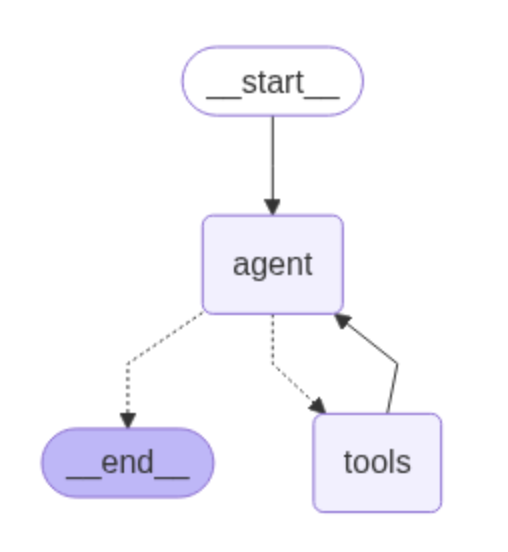

In [ ]:
from pathlib import Path
from datetime import datetime, date
from pydantic import BaseModel, Field
from langchain.tools import tool

from langchain_gigachat.chat_models import GigaChat
from langgraph.prebuilt import create_react_agent
from ddgs import DDGS

# ──────────────────────────────────────────────────────────────
DATA_DIR = Path("agent_data"); DATA_DIR.mkdir(exist_ok=True)

# ── append_to_file ──────────────────────────────────────────
class AppendArgs(BaseModel):
    filepath: str = Field(..., description="Имя текстового файла в ./agent_data")
    content:  str = Field(..., description="Текст для записи в файл")

@tool(
    args_schema=AppendArgs,
    description="Добавить строку в локальный текстовый файл (agent_data/...) "
)
def append_to_file(filepath: str, content: str) -> str:
    path  = DATA_DIR / Path(filepath).name                 # без ../
    stamp = datetime.now().strftime("[%d.%m.%Y %H:%M] ")   # DD.MM.YYYY
    with path.open("a", encoding="utf-8") as f:
        f.write(stamp + content.rstrip() + "\n")
    return f"✅ Записано в {path.name}"

# ── search_web ──────────────────────────────────────────────
@tool("search_web", description="Ищет в DuckDuckGo (RU, неделя, 5 ссылок)")
def search_web(query: str, max_results: int = 5) -> str:
    with DDGS() as ddgs:
        hits = ddgs.text(query, region="ru-ru", time="w", max_results=max_results)
        return "\n".join(f"{hit['title']}: {hit['body']} -- {hit['href']}" for hit in hits[:max_results])



### Tool

In [ ]:
today = date.today().strftime("%d.%m.%Y")  # DD.MM.YYYY
system_prompt = (
    f"Сегодня {today}. "
    "Ты полезный ассистент. Используй search_web для поиска в интернете, "
"append_to_file -- чтобы сохранять результаты."
)

### Agent

In [ ]:
agent = create_react_agent(model=llm,
                           tools=[search_web, append_to_file],
                           prompt=system_prompt)

In [ ]:
query = 'Сколько притоков у Реки Нил?'
resp = agent.invoke({"messages": [("user", query)]})
for message in resp["messages"]:
        message.pretty_print()

================================ Human Message =================================

Сколько притоков у Реки Нил?
================================== Ai Message ==================================
Tool Calls:
  search_web (95b6318f-0434-4bdf-8882-9433d9a18459)
 Call ID: 95b6318f-0434-4bdf-8882-9433d9a18459
  Args:
    query: Сколько притоков у реки Нил
================================= Tool Message =================================
Name: search_web

Нил — Википедия: В верхнем течении принимает крупные притоки — Эль-Газаль (левый) и Асуа, Собат, Голубой Нил и Атбара (правые). Ниже устья правого притока Атбары Нил течёт по полупустыне, не имея притоков (кроме временных рек) на протяжении последних 3000 км [5]. Водная система Нила считается самой длинной на Земле [6]. -- https://ru.wikipedia.org/wiki/Нил
Река Нил: сколько притоков?: Таким образом, река Нил имеет несколько притоков как на Верхнем, так и на Нижнем Ниле. Притоки Верхнего Нила включают реки Ручижи, Кагера и Полеси, а притоки Нижне

## Add Memory

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
checkpointer = MemorySaver()
agent = create_react_agent(
    model=llm,
    tools=[search_web, append_to_file],
    prompt=system_prompt,
    checkpointer=checkpointer # Memory
)

In [ ]:
def run(query: str, thread_id: str):

    config = {"configurable": {"thread_id": thread_id}}

    resp = agent.invoke({"messages": [("user", query)]}, config=config)
    for message in resp["messages"]:
        message.pretty_print()

In [ ]:
thread_id = 0
try:
        while True:
            q = input("> ").strip()
            if not q:
                break
            run(q, thread_id) # Передаем ID в функцию
except (KeyboardInterrupt, EOFError):
        pass

> Какая самая длинная река в мире?
================================ Human Message =================================

Какая самая длинная река в мире?
================================== Ai Message ==================================
Tool Calls:
  search_web (c0e29789-1cae-40a5-b3bf-fa7095166ce9)
 Call ID: c0e29789-1cae-40a5-b3bf-fa7095166ce9
  Args:
    query: самая длинная река в мире
================================= Tool Message =================================
Name: search_web

Амазонка — Википедия: ...измерениям составляет: от истока реки Мараньон — около 6400 км[1], от истока реки Апачет — 6992 км[2], от истока Укаяли — около 7100 км[1]. Амазонка со своим длиннейшим истоком претендует, вместе с Нилом, на статус самого длинного водотока в мире . -- https://ru.wikipedia.org/wiki/Амазонка
Бразильские ученые получили доказательства того, что самая ...: Ученым еще предстоит выбрать одну из двух точек, которые потенциально могут являться источником Амазонки. Но, по их словам, при любом 